In [1]:
#python specific stuff
import numpy as np
import matplotlib.pyplot as plt
import time
from functions import *
from ReadInParameters import *


In [2]:
## INITIALIZATION for time
total_time_h=3 #hours
t_step=1 #s
total_time_s=total_time_h*60*60
N_t_steps=int(total_time_s/t_step)

In [3]:
# # UPPER ROOM INITIALIZATION #########################
[lower,middle,upper,output_surface_array_lower,output_surface_array_middle,output_surface_array_upper,T_target,T_exterior,target_level]=ReadInParameters('UserInputSheet.xlsx')


## DO CALCULATION ##################

data_array_T_room_upper=np.zeros(int(N_t_steps))
data_array_T_room_middle=np.zeros(int(N_t_steps))
data_array_T_room_lower=np.zeros(int(N_t_steps))

Qin_cumul=[0]

for t in range(N_t_steps):

    data_array_T_room_upper[t]=upper.T_room
    data_array_T_room_middle[t]=middle.T_room
    data_array_T_room_lower[t]=lower.T_room
    
    ## LAYER 1
    
    #do surfaces in upper room
    [Qout_room_total,output_surface_array_upper]=do_surfaces_in_room(output_surface_array_upper,upper.T_room,t_step,T_exterior)
    #now conductive to lower room
    Qout_upper_to_middle=calculate_Qout_convective(upper.U,upper.area,upper.T_room,middle.T_room)
    Qout_room_total=Qout_room_total+Qout_upper_to_middle
    
    #temp monitoring - for now NO CHANGE

    if lower.T_room >= T_target:
        upper.Qin=1*upper.Qin_max
        middle.Qin=1*middle.Qin_max
        lower.Qin=1*lower.Qin_max
    else:
        upper.Qin=upper.Qin_max
        middle.Qin=middle.Qin_max
        lower.Qin=lower.Qin_max
    
    #update Temp of room using Qins and Qouts
    Q_leak_upper=upper.airchanges_per_hour*upper.volume*t_step*upper.densityC*(upper.T_room-T_exterior)/3600
    upper.T_room=upper.T_room+calculate_Tchange(upper.Qin-Q_leak_upper,Qout_room_total,t_step,upper.densityC,upper.volume)
    
    ## LAYER 2
    ##bug here in line 43
    [Qout_room_total,output_surface_array_middle]=do_surfaces_in_room(output_surface_array_middle,middle.T_room,t_step,T_exterior)
    Qout_middle_to_lower=calculate_Qout_convective(middle.U,middle.area,middle.T_room,lower.T_room)
    Qout_room_total=Qout_room_total+Qout_middle_to_lower
    
    #Calculate cumulative heat input:
    Q_leak_middle=middle.airchanges_per_hour*middle.volume*t_step*middle.densityC*(middle.T_room-T_exterior)/3600
    middle.T_room=middle.T_room+calculate_Tchange(middle.Qin+Qout_upper_to_middle-Q_leak_middle,Qout_room_total,t_step,middle.densityC,middle.volume)
    
    ## LAYER 3
    
    [Qout_room_total,output_surface_array_lower]=do_surfaces_in_room(output_surface_array_lower,lower.T_room,t_step,T_exterior)

    #Calculate cumulative heat input:
    Q_leak_lower=lower.airchanges_per_hour*lower.volume*t_step*lower.densityC*(lower.T_room-T_exterior)/3600
    lower.T_room=lower.T_room+calculate_Tchange(lower.Qin+Qout_middle_to_lower-Q_leak_lower,Qout_room_total,t_step,lower.densityC,lower.volume)
    ## CUMUL Q
    
    Qin_cumul=np.append(Qin_cumul,Qin_cumul[t]+lower.Qin*t_step +middle.Qin*t_step+upper.Qin*t_step)  

C:\Users\EH842\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


19.84615693475257


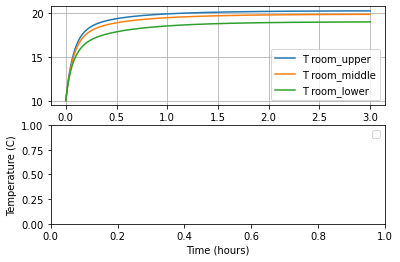

In [4]:
# MAKE PLOTS ##########################
fig, axs = plt.subplots(2)
t_array=np.arange(0,N_t_steps*t_step,t_step)/(60*60)
axs[0].plot(t_array,data_array_T_room_upper,label='T room_upper')
axs[0].plot(t_array,data_array_T_room_middle,label='T room_middle')
axs[0].plot(t_array,data_array_T_room_lower,label='T room_lower')
axs[0].legend()
axs[1].legend()
axs[0].grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')
print(data_array_T_room_middle[-1])

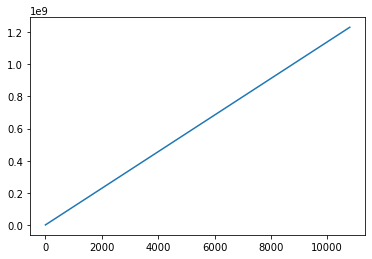

In [5]:
plt.plot( Qin_cumul)